In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import sqlite3
import pandas as pd
from lsst.sims.featureScheduler.utils import standard_goals
import healpy as hp
from lsst.sims.utils import hpid2RaDec
from scipy.stats import binned_statistic
import glob

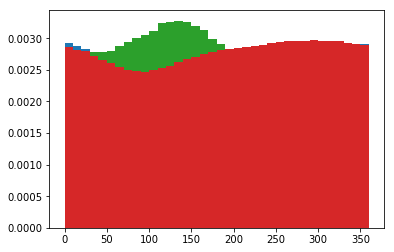

In [2]:

files = glob.glob('../weather/*10yrs.db')
bins = np.arange(0,361, 10)

curves = []
for filename in files:
    conn = sqlite3.connect(filename)
    df = pd.read_sql('select observationStartLST,fieldRA from SummaryAllProps;', conn)
    ack = plt.hist(df['observationStartLST'], bins=bins, normed=True)
    curves.append(ack[0])
    conn.close()




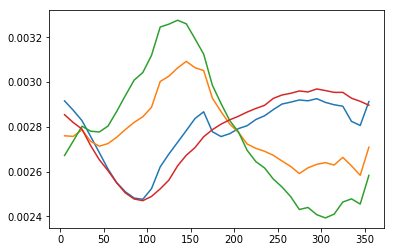

In [3]:
bc = (ack[1][0:-1]+ack[1][1:])/2.
for curve in curves:
    plt.plot(bc, curve)

In [4]:
nside = 32
sg = standard_goals(nside=nside)
total_requested = sg['r']*0
for key in sg:
    total_requested += sg[key]

In [5]:
ra,dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
binned_requested, be, bn = binned_statistic(ra, total_requested, statistic=np.sum, bins=bins)

br = binned_requested/(np.sum(binned_requested)*(be[1]-be[0]))

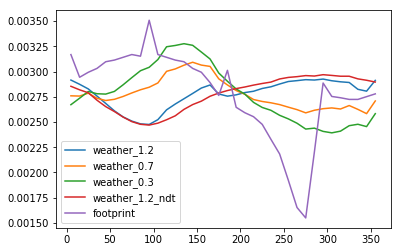

In [6]:
bc = (ack[1][0:-1]+ack[1][1:])/2.

for curve,fn in zip(curves, files):
    label = fn.split('/')[-1][0:-14]
    plt.plot(bc, curve, label=label)
plt.plot(bc, br, label='footprint')
plt.legend()

So, interesting results:
* Weather radically shifts the time of year when peak time is available.
* Even going from no-weather to lots of weather, the default footprint has a huge under-subscription at RA=275, and and over-subscription at RA=60. 

So when the scheduler gets done with the galactic plane, the spot on the sky it needs to catch up on is 145 degrees away in RA! Seems like it's a good idea to move some of the footprint area to RA's at least near the Galactic plane. Or make a WFD bridge through the Galactic plane to help bring up that minimum.

Note the requested footprint is not including the DDF time. So that could shift the over-subscribed peak a bit (but still in the wrong place).